In [16]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates
import numpy as np

In [2]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-22", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df.index = msft_df.index.tz_localize(None)

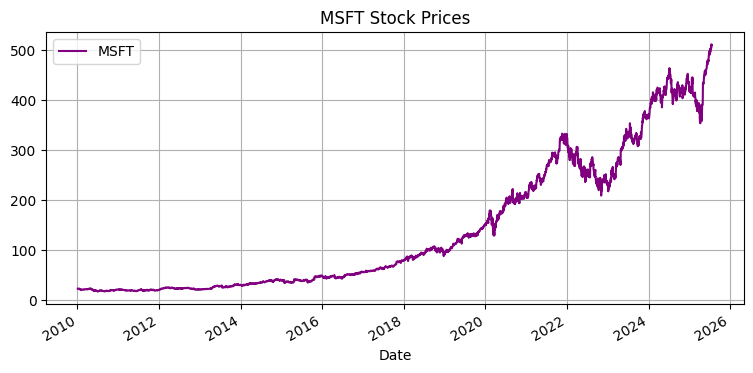

In [3]:
plt.subplots(figsize=(9, 4))
msft_df['Close'].plot(label='MSFT', color='purple')
plt.title('MSFT Stock Prices')
plt.grid()
plt.legend()

# 1. First attempt: RF regression with lags as variables

In [23]:
split_date = pd.Timestamp("2024-07-02")

def create_features(df, window=200):
    X = pd.DataFrame(index=df.index)
    for i in range(1, window+1):
        X[f"lag_{i}"] = df["Close"].shift(i)
    X.dropna(inplace=True)
    return X

# 1. Build features and align targets
features = create_features(msft_df, window=20)
targets  = msft_df["Close"].loc[features.index]

# 2. Split into train/test
train_X = features.loc[: split_date - pd.Timedelta(days=1)]
train_y = targets.loc[train_X.index]

test_X  = features.loc[split_date: ]
test_y  = targets.loc[test_X.index]

# 3. Fit and score
rf = RandomForestRegressor(n_estimators=200, random_state=42, max_features=1/2,
                           max_depth=10, min_samples_leaf=5, n_jobs=-1)
rf.fit(train_X, train_y)

preds = rf.predict(test_X)

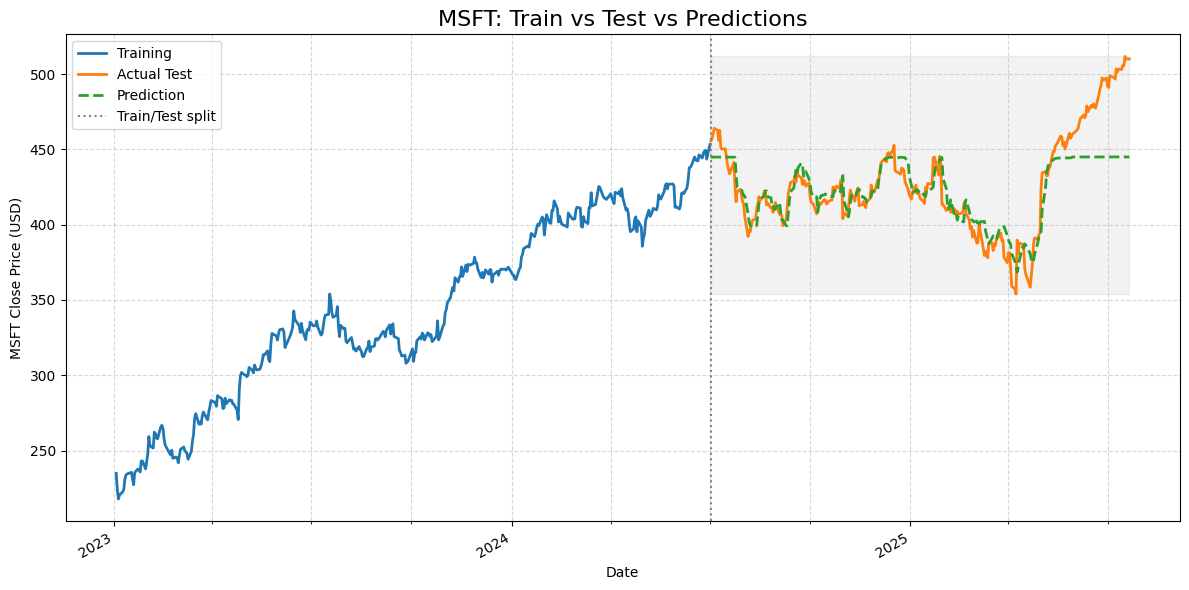

In [24]:
# Assume split_date is already a pd.Timestamp
fig, ax = plt.subplots(figsize=(12, 6))

# 1. Plot train, test, and predictions with thicker lines
ax.plot(train_y.loc['2023-01-01':].index, train_y.loc['2023-01-01':],     label="Training",    linewidth=2)
ax.plot(test_y.index,  test_y,      label="Actual Test",  linewidth=2)
ax.plot(test_y.index,  preds,       label="Prediction",   linewidth=2, linestyle="--")

# 2. Vertical line denoting the split
ax.axvline(split_date, color="gray", linestyle=":", label="Train/Test split")

# 3. Highlight test region
ax.fill_between(test_y.index, 
                test_y.min(), test_y.max(), 
                color="gray", alpha=0.1)

# 4. Axes labels & title
ax.set_xlabel("Date")
ax.set_ylabel("MSFT Close Price (USD)")
ax.set_title("MSFT: Train vs Test vs Predictions", fontsize=16)

# 5. Grid, legend, date formatting
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(loc="upper left")

# Use nice tick spacing & rotation
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


# 2. Evaluate MSE for different amount of lags

In [11]:
lags_MSE = []
for lag_num in range(5, 366, 5):
    # 1. Build features and align targets
    features = create_features(msft_df, window=20)
    targets  = msft_df["Close"].loc[features.index]

    # 2. Split into train/test
    train_X = features.loc[: split_date - pd.Timedelta(days=1)]
    train_y = targets.loc[train_X.index]

    test_X  = features.loc[split_date: ]
    test_y  = targets.loc[test_X.index]
    
    # 3. Fit and score
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_X, train_y)
    preds = rf.predict(test_X)
    
    # Calculate MSE
    mse = ((preds - test_y) ** 2).mean()
    lags_MSE.append((lag_num, mse))

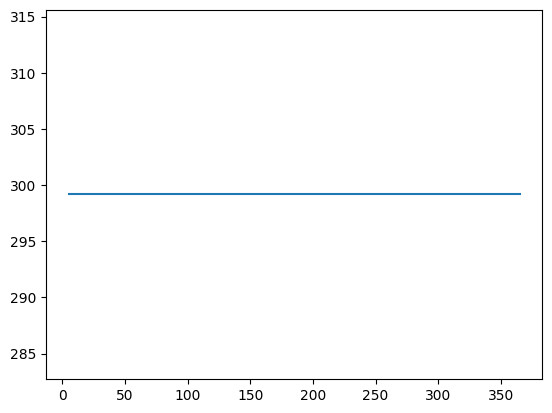

In [12]:
plt.plot([l[0] for l in lags_MSE], [l[1] for l in lags_MSE])